# Udacity Self-Driving Car Nanodegree

## Advanced Lane Finding Project

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

# Camera calibration

For this project the calibration images were taken from a different camera setting than the examples in the course, so we need to make sure that the chessboard size for calibration is set to 9x6 instead of 8x6.

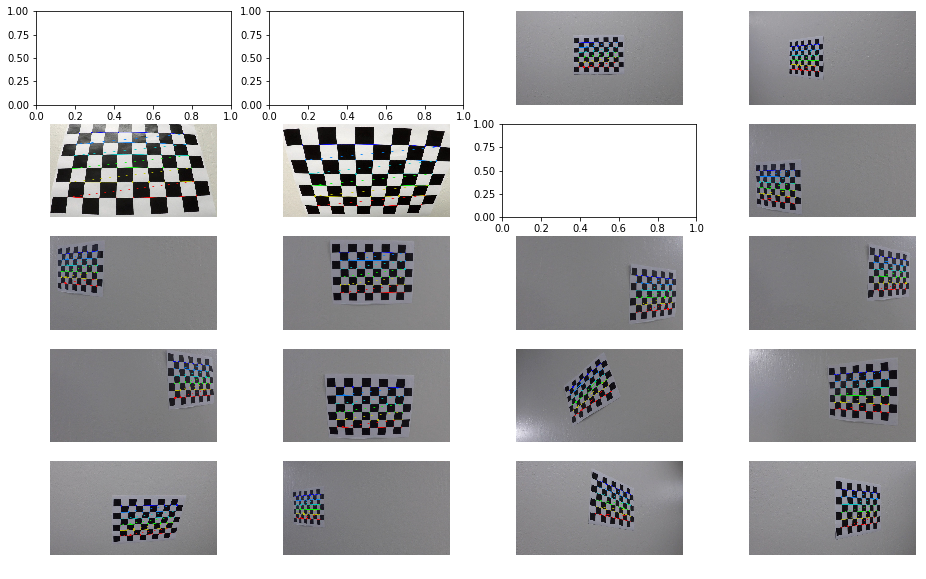

In [2]:
# Prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Read in and make a list of calibration images.
images = glob.glob('./camera_cal/calibration*.jpg')

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 10))
ax = ax.ravel()

for i, file_name in enumerate(images):
    image = mpimg.imread(file_name)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6),None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
        img = cv2.drawChessboardCorners(image, (9, 6), corners, ret)
        ax[i].axis('off')
        ax[i].imshow(img)

empty images displayed in the plot above indicate calibration images where chessboard corners were not found.

# Undistort image

Now test the values found in the previous step to verify that the camera was calibrated correctly.

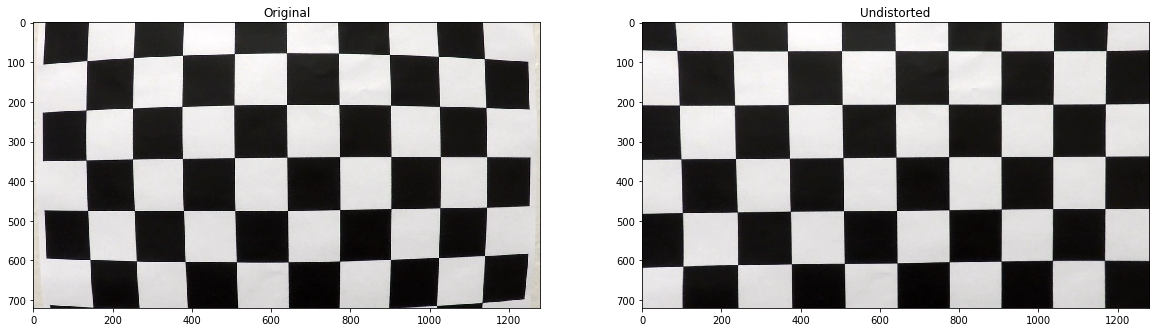

In [3]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
dst = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(img)

ax2.set_title('Undistorted')
ax2.imshow(dst, cmap='gray')

## Undistort one of the sample images

Now let's verify if the calibration is working correctly for a random test image taken from the car dashbord.

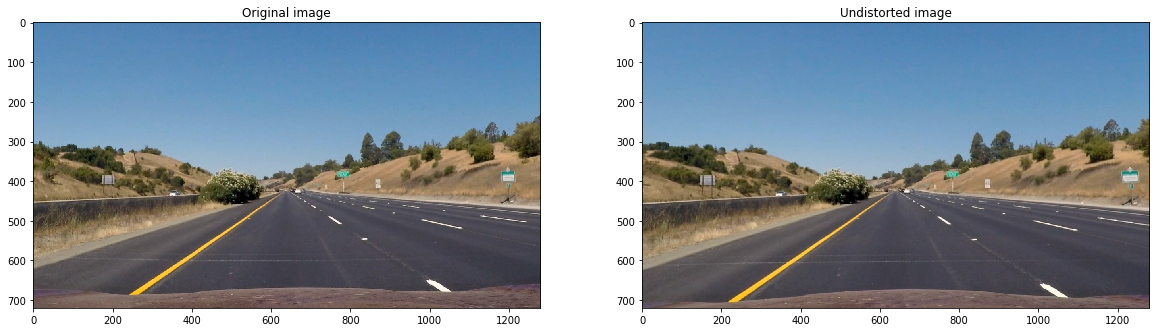

In [4]:
test_image = mpimg.imread('./test_images/straight_lines1.jpg')

undistort_image = undistort(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original image')
ax1.imshow(test_image)

ax2.set_title('Undistorted image')
ax2.imshow(undistort_image, cmap='gray')

# Perspective transform

Change the image perspective to be see the road from above, this will help detect lanes and obstacles.

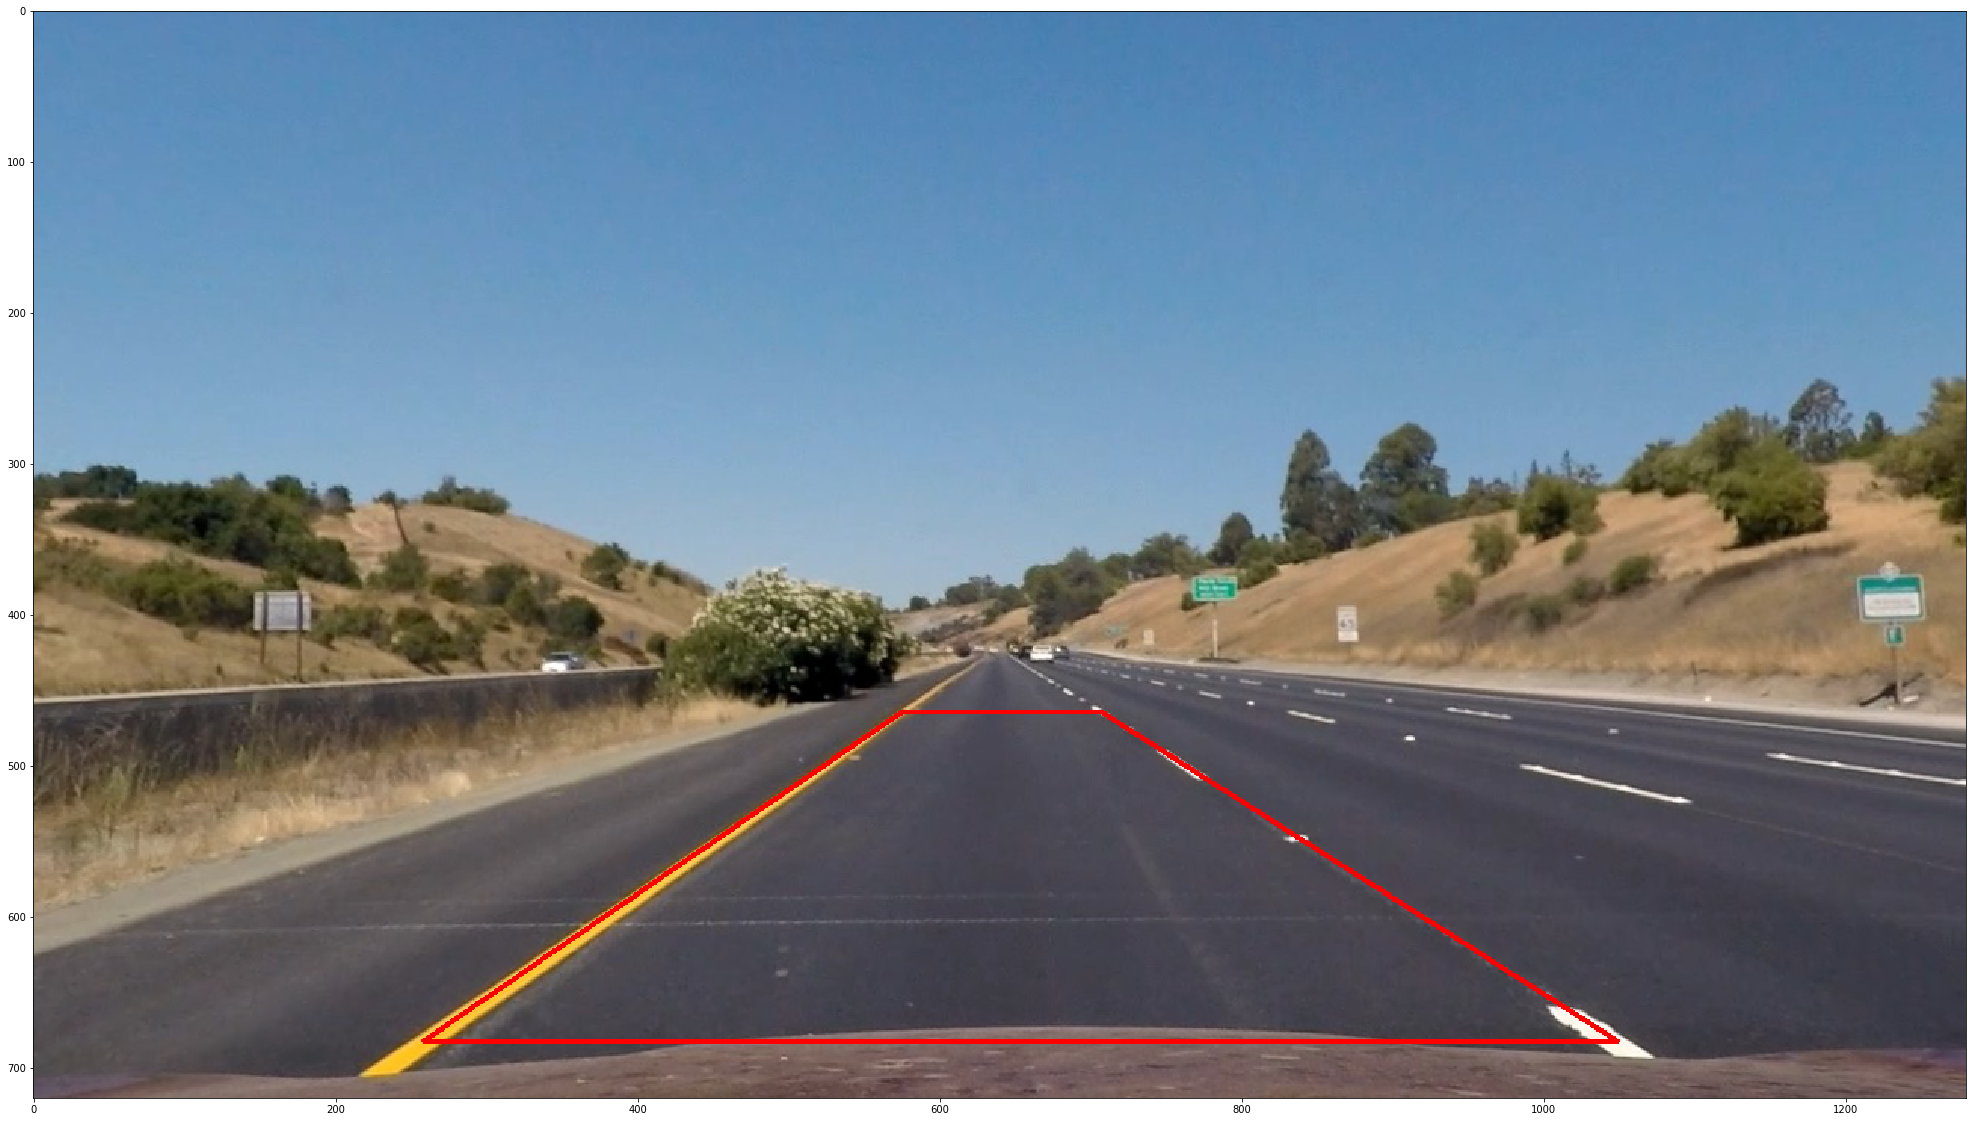

In [5]:
xSize, ySize, _ = undistort_image.shape
copy = undistort_image.copy()

bottomY = 682
topY = 464

left1 = (258, bottomY)
left1_x, left1_y = left1
left2 = (575, topY)
left2_x, left2_y = left2

right1 = (707, topY)
right1_x, right1_y = right1

right2 = (1049, bottomY)
right2_x, right2_y = right2

color = [255, 0, 0]
w = 2
cv2.line(copy, left1, left2, color, w)
cv2.line(copy, left2, right1, color, w)
cv2.line(copy, right1, right2, color, w)
cv2.line(copy, right2, left1, color, w)
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(copy)

In [6]:
src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])
img_size = (copy.shape[1], copy.shape[0])
offset = 300
dst = np.float32([
    [offset, 0],
    [img_size[0]-offset, 0],
    [img_size[0]-offset, img_size[1]], 
    [offset, img_size[1]]
])

print(src, dst)

def transform_image(img):
    h,w = img.shape[:2]
    img_size = (img.shape[1], img.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
     # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

[[ 575.  464.]
 [ 707.  464.]
 [1049.  682.]
 [ 258.  682.]] [[300.   0.]
 [980.   0.]
 [980. 720.]
 [300. 720.]]


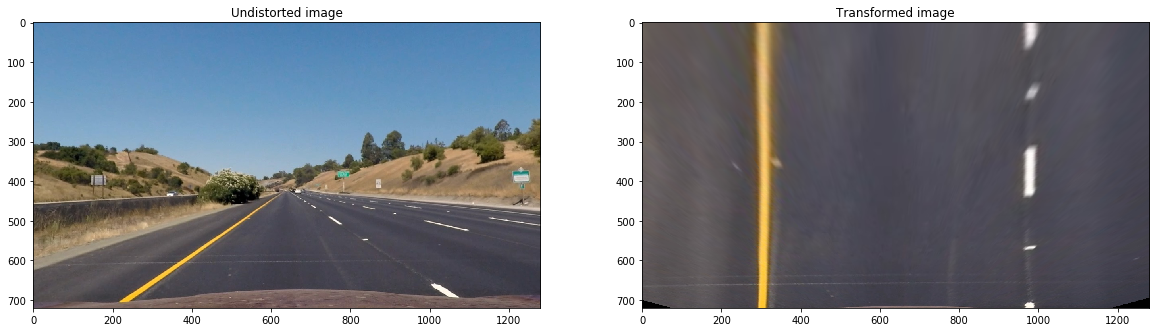

In [7]:
tranformed_image, M, Minv = transform_image(undistort_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image')
ax1.imshow(undistort_image)

ax2.set_title('Transformed image')
ax2.imshow(tranformed_image, cmap='gray')

# Color spaces

A color space is a specific organization of colors; color spaces provide a way to categorize colors and represent them in digital images.

In this project I am going to test for images in RGB and HLS, usually the S channel of the HLS color space provides the best results.

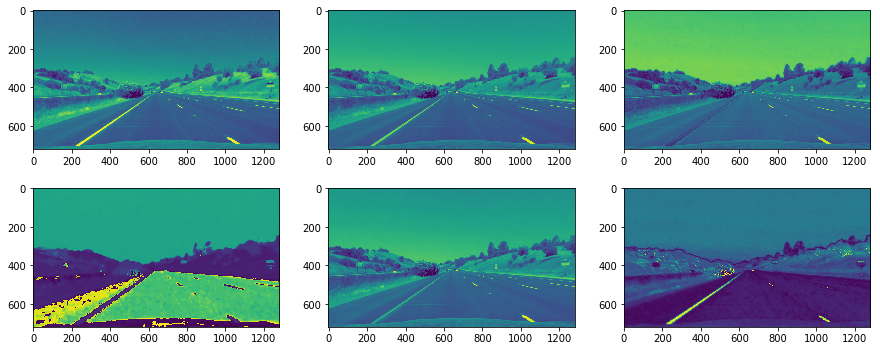

In [8]:
hls_undistort_image = cv2.cvtColor(undistort_image, cv2.COLOR_RGB2HLS)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
axs = axs.ravel()
axs[0].imshow(undistort_image[:,:,0])
axs[1].imshow(undistort_image[:,:,1])
axs[2].imshow(undistort_image[:,:,2])
axs[3].imshow(hls_undistort_image[:,:,0])
axs[4].imshow(hls_undistort_image[:,:,1])
axs[5].imshow(hls_undistort_image[:,:,2])

# Applying Sobel

Applying sobel helps identify the lanes, detecting edges on the image 
Sobel in the x emphasizes edges closer to vertical. Alternatively, taking the sobel in the y direction emphasizes edges closer to horizontal.

In [9]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_sobel_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [10]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
     # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [11]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_sobel_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1


    # Return the binary image
    return binary_output

## Sobel absolute threshold

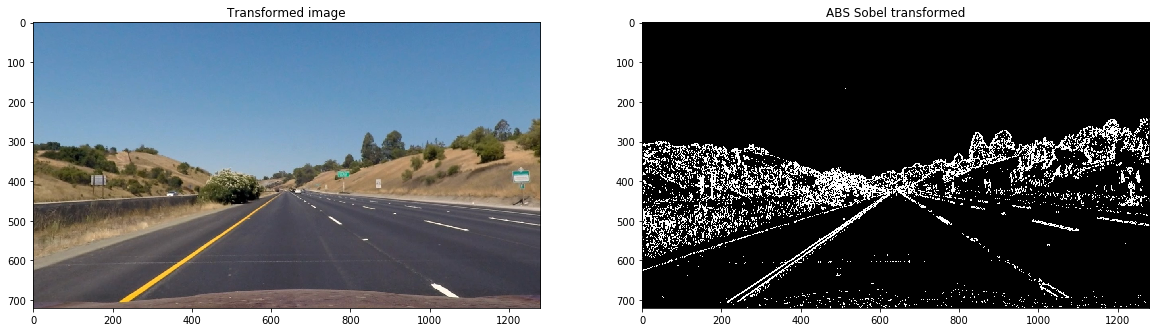

In [12]:
abs_sobel_image = abs_sobel_thresh(undistort_image, orient='x', thresh_min=10, thresh_max=150)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Transformed image')
ax1.imshow(undistort_image)

ax2.set_title('ABS Sobel transformed')
ax2.imshow(abs_sobel_image, cmap='gray')

## Sobel magnitude threshold

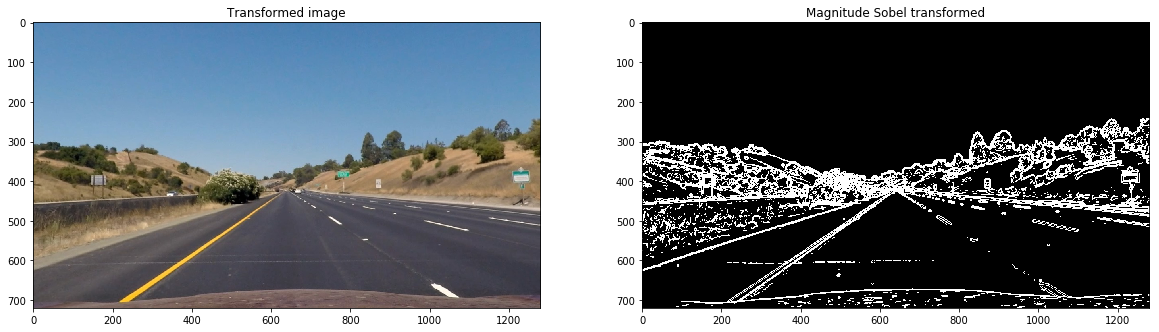

In [13]:
mag_sobel_undistor_image = mag_sobel_thresh(undistort_image, sobel_kernel=7, mag_thresh=(20, 150))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Transformed image')
ax1.imshow(undistort_image)

ax2.set_title('Magnitude Sobel transformed')
ax2.imshow(mag_sobel_undistor_image, cmap='gray')

## Sobel direction threshold

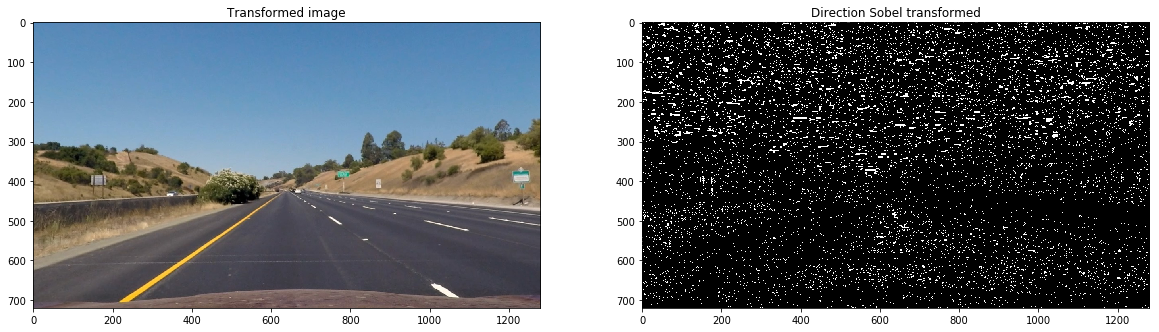

In [14]:
dir_sobel_undistort_mage = dir_sobel_threshold(undistort_image, sobel_kernel=5, thresh=(0, 0.1))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Transformed image')
ax1.imshow(undistort_image)

ax2.set_title('Direction Sobel transformed')
ax2.imshow(dir_sobel_undistort_mage, cmap='gray')

## Combine Sobel and HLS threshold

In [15]:
def sobel_hls_threshold(img, s_thresh=(90, 255), sx_thresh=(20, 255), l_thresh=(40,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Grayscale image
    sxbinary = abs_sobel_thresh(img, orient='x', thresh_min=sx_thresh[0], thresh_max=sx_thresh[1])
    
    # Threshold color channel
    s_thresh_min, s_thresh_max = s_thresh
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) & (l_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

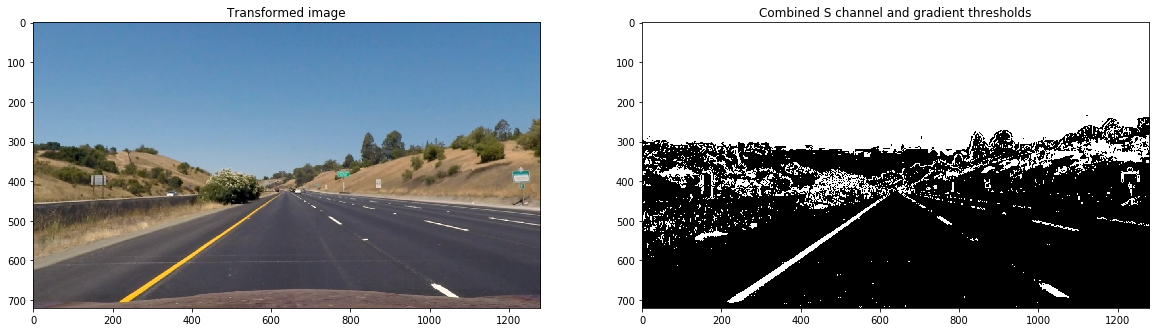

In [16]:
combined_binary = sobel_hls_threshold(undistort_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Transformed image')
ax1.imshow(undistort_image)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

# Image processing pipeline

The pipeline will undistort, transform the image perspective and then get the combined image for S channel and gradient thresholds.

In [17]:
def process_image(img):
    # Undistort the image
    undistord_img = undistort(img)
    # Combined image
    combined_img = sobel_hls_threshold(undistord_img)
    # Transform the image perspective
    transformed_img, M, Minv = transform_image(combined_img)
    
    return transformed_img, M, Minv

## Verify the pipeline result for all the test images

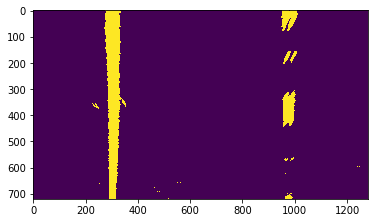

In [18]:
processed_test_image, _, _ = process_image(test_image)
plt.imshow(processed_test_image)

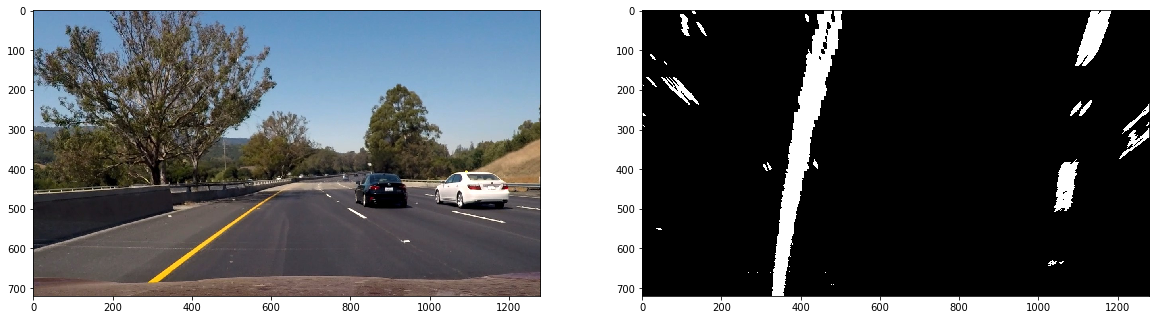

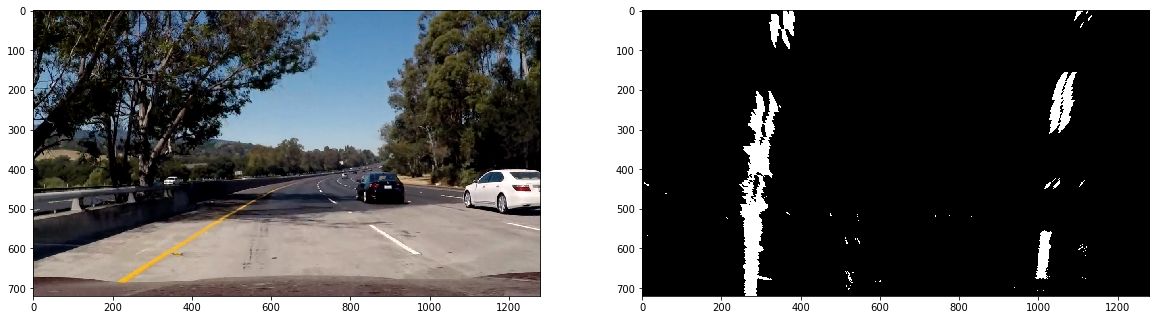

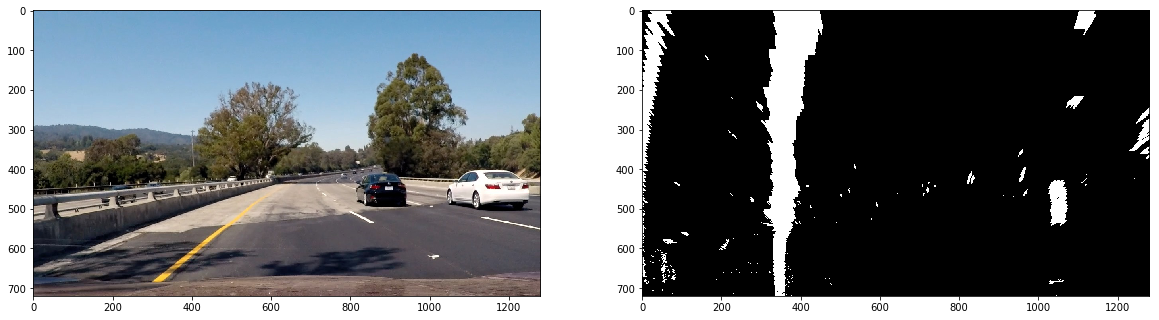

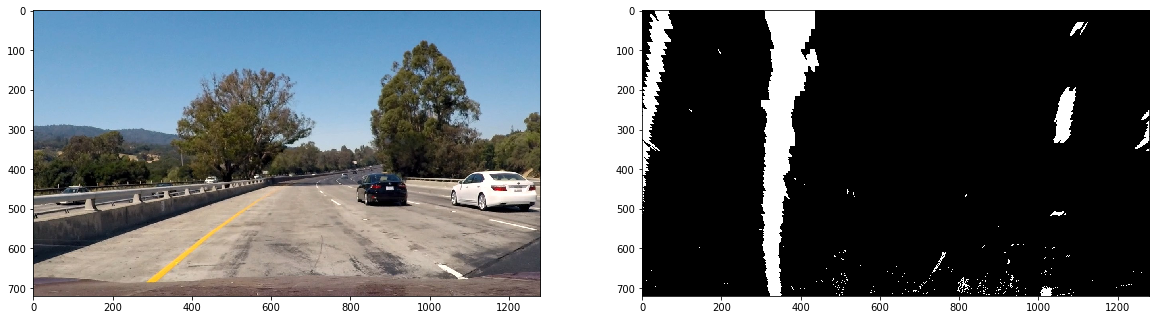

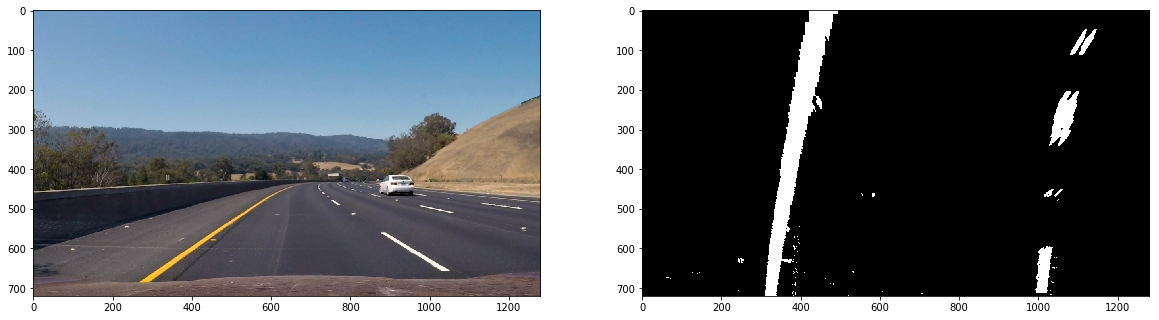

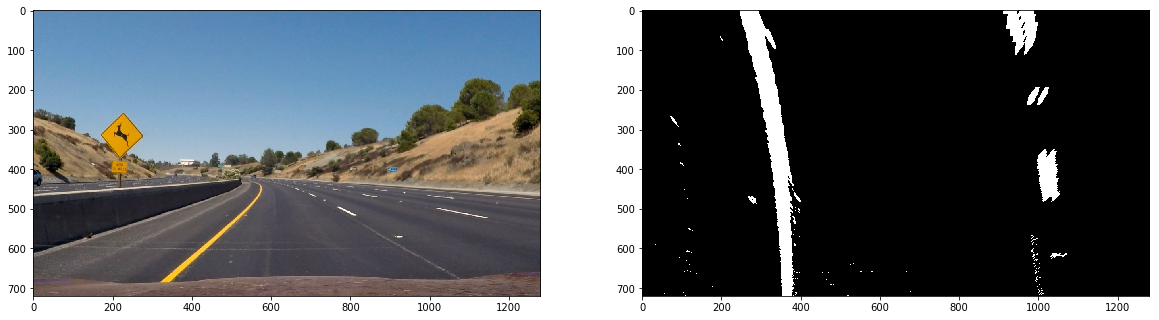

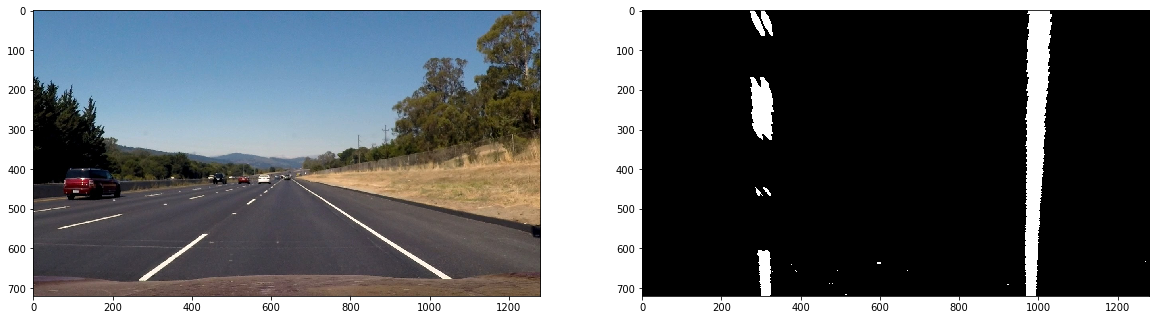

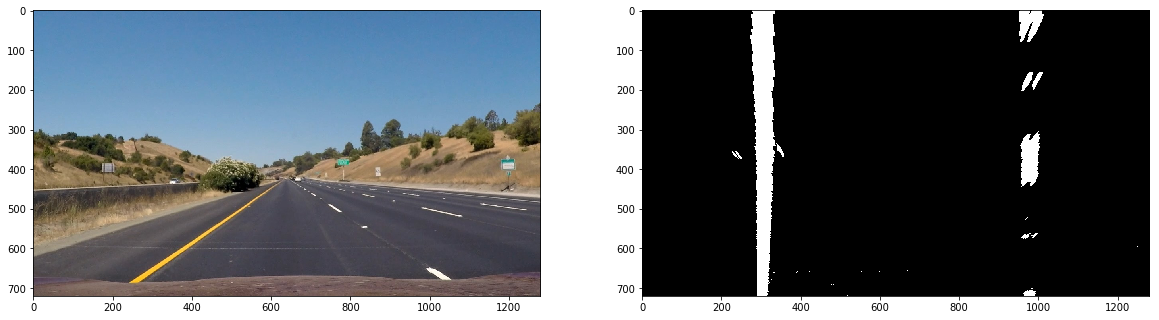

In [19]:
test_images = glob.glob('./test_images/*.jpg')

for file_name in test_images:
    image = mpimg.imread(file_name)
    processed_image, M, Minv = process_image(image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax2.imshow(processed_image, cmap='gray')

# Locate the Lane Lines and Fit a Polynomial

In [20]:
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

In [21]:
left_fit, right_fit, left_lane_inds, right_lane_inds, (rectangle_visualization_data, histogram) = sliding_window_polyfit(processed_test_image)

(640, 720, 192, 392, 866, 1066)
(560, 640, 204, 404, 876, 1076)
(480, 560, 205, 405, 874, 1074)
(400, 480, 206, 406, 874, 1074)
(320, 400, 208, 408, 875, 1075)
(240, 320, 208, 408, 877, 1077)
(160, 240, 207, 407, 886, 1086)
(80, 160, 205, 405, 879, 1079)
(0, 80, 204, 404, 889, 1089)


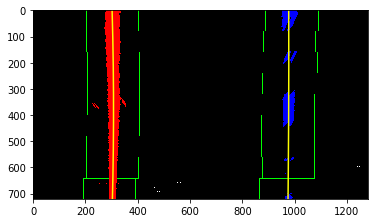

In [22]:
def plot_sliding_window_results(img, left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_visualization_data):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = processed_test_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Draw the windows on the visualization image
    for rectangle in rectangle_visualization_data:
        win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = rectangle
        print(rectangle)
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
plot_sliding_window_results(processed_test_image, left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_visualization_data)

(0, 1280)

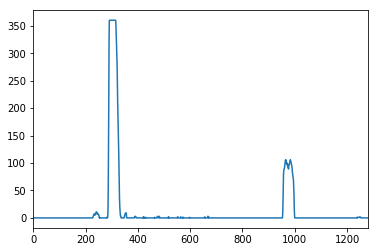

In [23]:
plt.plot(histogram)
plt.xlim(0, 1280)

# Polifit using fit data previous frame 

In [24]:
def polyfit_using_prev_fit(img, prev_left_fit, prev_right_fit):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] - margin)) & 
                      (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] - margin)) & 
                       (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

Visualize the results of this polyfit using the next image test6.jpg

(720, 0)

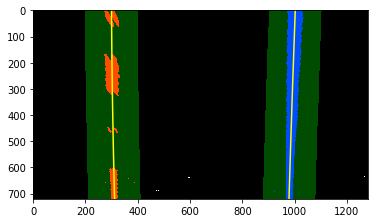

In [25]:
next_image = mpimg.imread('./test_images/straight_lines2.jpg')
next_processed_image, next_M, next_Minv = process_image(next_image)
margin = 100

next_left_fit, next_right_fit, next_left_lane_inds, next_right_lane_inds = polyfit_using_prev_fit(next_processed_image, left_fit, right_fit)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((next_processed_image, next_processed_image, next_processed_image))*255
window_img = np.zeros_like(out_img)

nonzero = next_processed_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Color in left and right line pixels
out_img[nonzeroy[next_left_lane_inds], nonzerox[next_left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[next_right_lane_inds], nonzerox[next_right_lane_inds]] = [0, 0, 255]

# Identify the x and y positions of all nonzero pixels in the image
nonzero = out_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Generate x and y values for plotting
ploty = np.linspace(0, next_image.shape[0]-1, next_image.shape[0] )
left_fitx = next_left_fit[0]*ploty**2 + next_left_fit[1]*ploty + next_left_fit[2]
right_fitx = next_right_fit[0]*ploty**2 + next_right_fit[1]*ploty + next_right_fit[2]

# Generate a polygon to illustrate the search window area
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Calculate curvature and distance from the center

In [26]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

Print the calculation for the test image.

In [27]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(processed_test_image, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 4365.114270191554 m, 16835.225741223974 m
Distance from lane center for example: 0.005040373888395672 m


In [28]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

Draw the lane for the test image

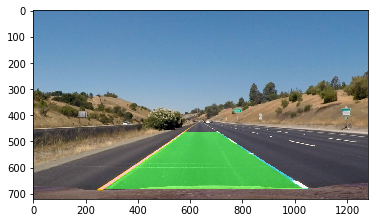

In [29]:
test_image_withlane  = draw_lane(test_image, processed_test_image, left_fit, right_fit, Minv)
plt.imshow(test_image_withlane)

In [30]:
def draw_image_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 2, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction
    cv2.putText(new_img, text, (40,120), font, 2, (200,255,155), 2, cv2.LINE_AA)
    return new_img

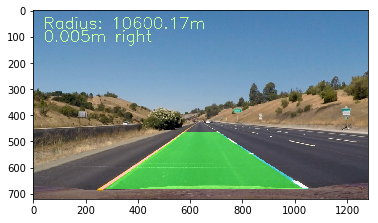

In [31]:
test_image_with_data = draw_image_data(test_image_withlane, (rad_l+rad_r)/2, d_center)
plt.imshow(test_image_with_data)

# Video pipeline

In [32]:
# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None 
        
    def add_fit(self, fit, inds):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)

In [33]:
def process_video_image(img):
    new_img = np.copy(img)
    img_bin, M, Minv = process_image(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, (rectangle_visualization_data, histogram) = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_image_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
        
    return img_out

## Verify processing pipeline

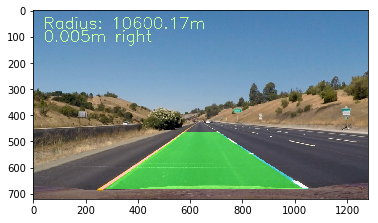

In [34]:
l_line =  Line()
r_line =  Line()

straight_line_image = mpimg.imread('./test_images/straight_lines1.jpg')
processed_straight_line_image = process_video_image(straight_line_image)

plt.imshow(processed_straight_line_image)

# Process project video

In [35]:
l_line =  Line()
r_line =  Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_video_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:50<00:00,  7.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 39s, sys: 31.1 s, total: 3min 10s
Wall time: 2min 51s


# Challenge video

In [36]:
l_line = Line()
r_line = Line()

video_output3 = 'challenge_video_output.mp4'
video_input3 = VideoFileClip('challenge_video.mp4')
processed_video = video_input3.fl_image(process_video_image)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:01<00:00,  7.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 57.8 s, sys: 10.8 s, total: 1min 8s
Wall time: 1min 2s


# Harder challenge video

In [37]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')
processed_video = video_input3.fl_image(process_video_image)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:35<00:00,  5.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 9s, sys: 34.1 s, total: 3min 43s
Wall time: 3min 37s
